In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    color = 'r'
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =4.06197e-22

nband = 340

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 20

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

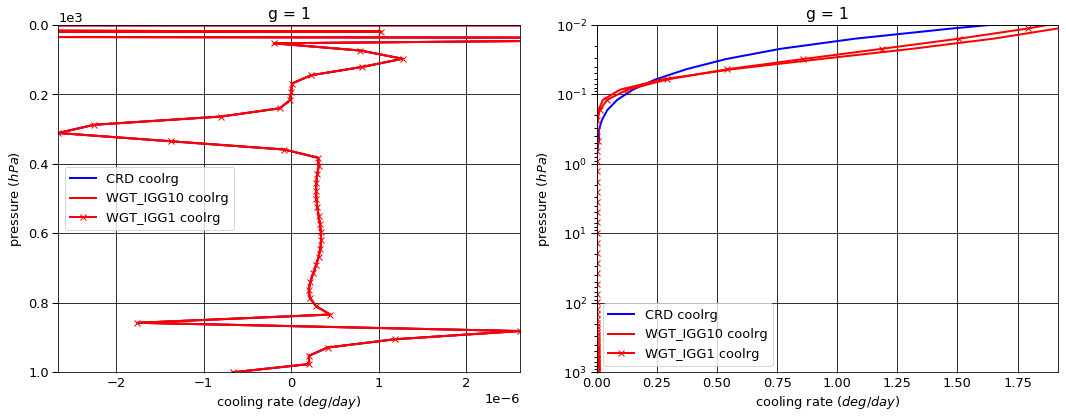

# Figure: cooling rate g-group 2

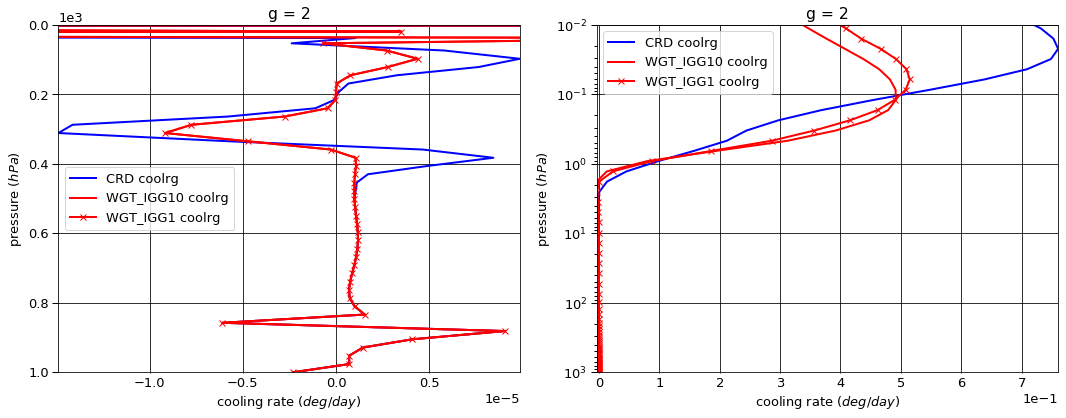

# Figure: cooling rate g-group 3

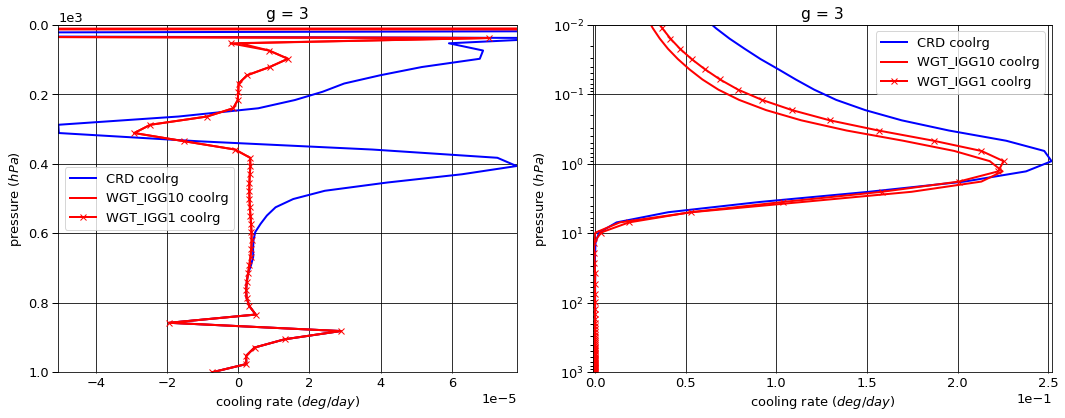

# Figure: cooling rate g-group 4

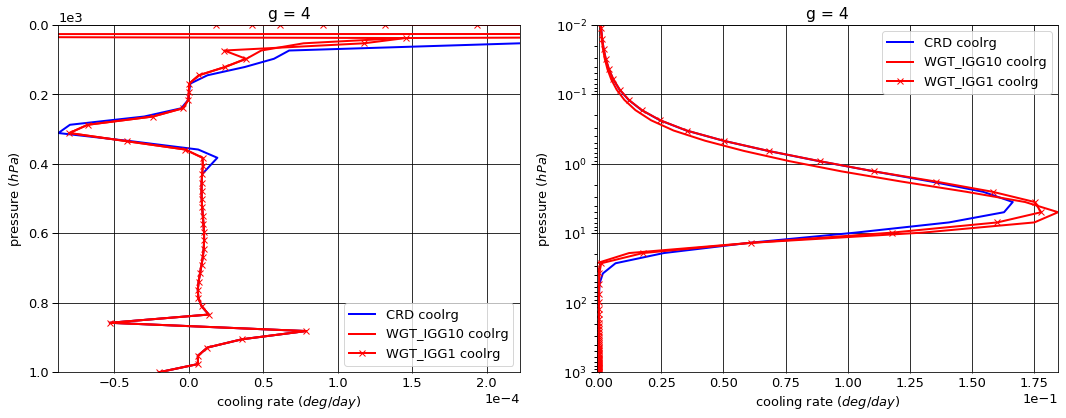

# Figure: cooling rate g-group 5

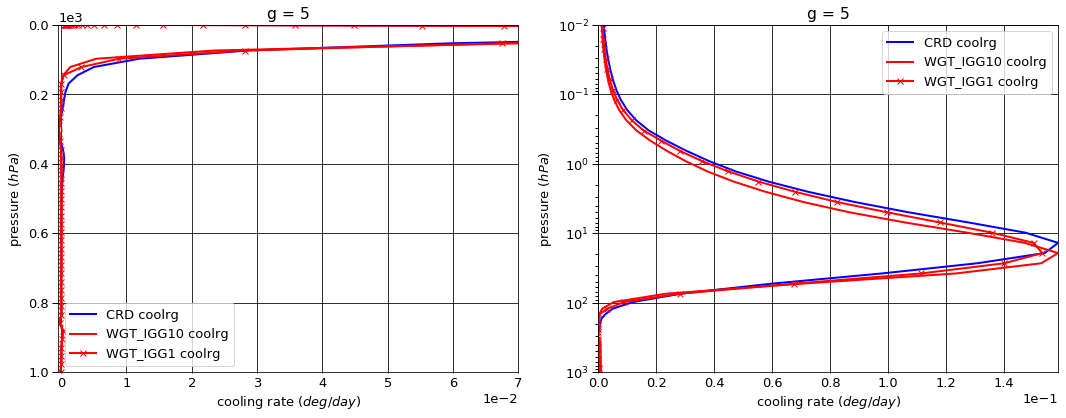

# Figure: cooling rate g-group 6

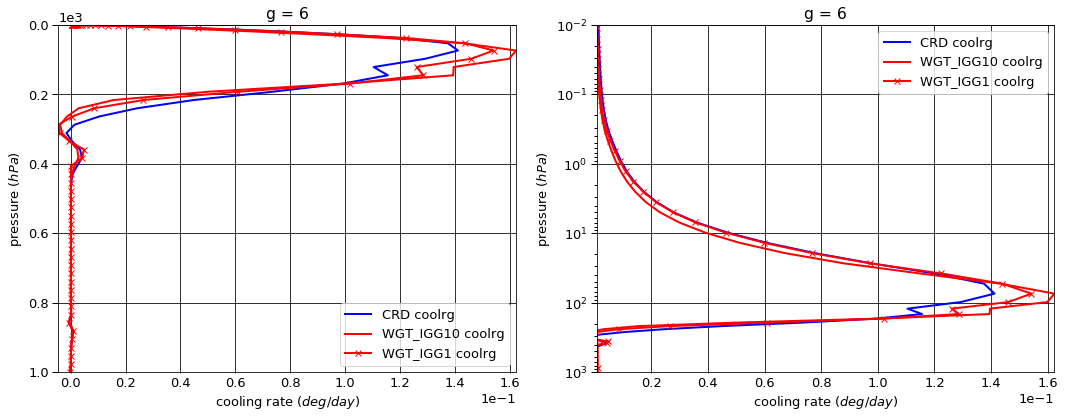

# Figure: cooling rate g-group 7

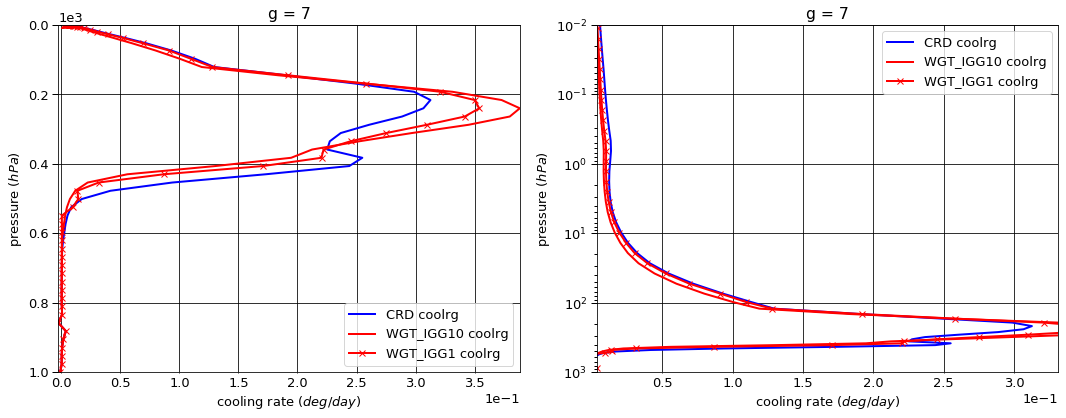

# Figure: cooling rate g-group 8

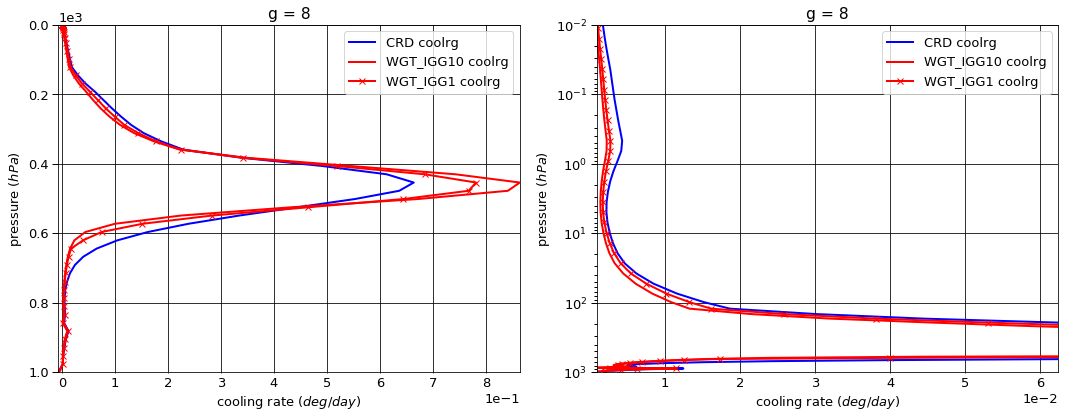

# Figure: cooling rate g-group 9

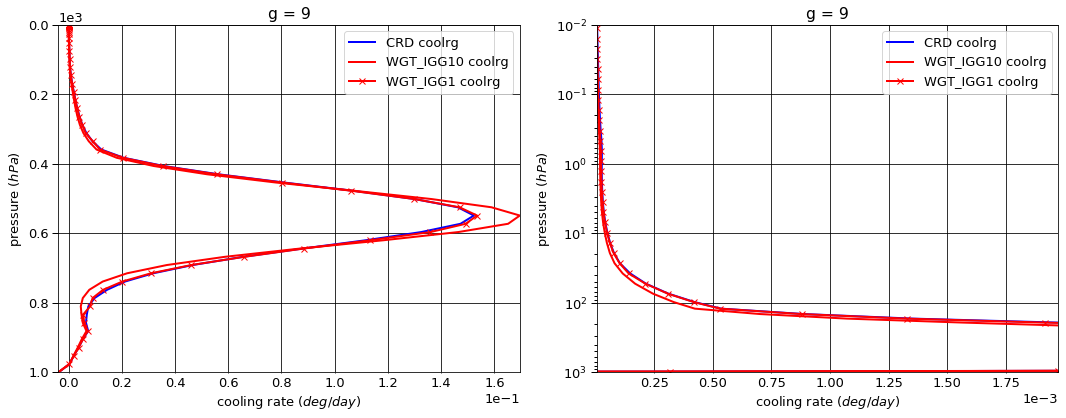

# Figure: cooling rate g-group total

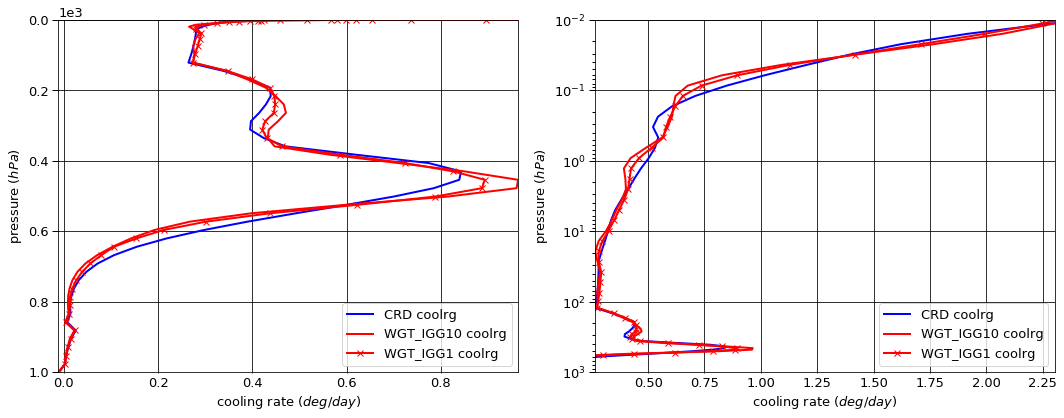

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.008669   0.000000  -0.008669
  1013.0   76     -0.010211   0.010213   0.000002
2 0.0      1      -0.032629   0.000000  -0.032629
  1013.0   76     -0.034344   0.034352   0.000008
3 0.0      1      -0.095223   0.000000  -0.095223
  1013.0   76     -0.110099   0.110125   0.000025
4 0.0      1      -0.235271   0.000000  -0.235271
  1013.0   76     -0.307355   0.307424   0.000069
5 0.0      1      -0.906669   0.000000  -0.906669
  1013.0   76     -1.253690   1.253975   0.000285
6 0.0      1      -2.855176   0.000000  -2.855176
  1013.0   76     -3.908027   3.908909   0.000882
7 0.0      1     -10.994841   0.000000 -10.994841
  1013.0   76    -14.610366  14.613756   0.003390
8 0.0      1     -16.768362   0.000000 -16.768362
  1013.0   76    -20.519140  20.545284   0.026143
9 0.0      1      -4.157776   0.000000  -4.157776
  1013.0   76     -4.770861   4.790855   0.019995


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.008744   0.000000  -0.008744
  1013.0   76     -0.010211   0.010213   0.000002
2 0.0      1      -0.033352   0.000000  -0.033352
  1013.0   76     -0.034344   0.034352   0.000008
3 0.0      1      -0.094395   0.000000  -0.094395
  1013.0   76     -0.110099   0.110125   0.000025
4 0.0      1      -0.236079   0.000000  -0.236079
  1013.0   76     -0.307355   0.307424   0.000069
5 0.0      1      -0.902655   0.000000  -0.902655
  1013.0   76     -1.253690   1.253974   0.000284
6 0.0      1      -2.853592   0.000000  -2.853592
  1013.0   76     -3.908027   3.908909   0.000882
7 0.0      1     -10.859238   0.000000 -10.859238
  1013.0   76    -14.610366  14.613695   0.003328
8 0.0      1     -16.644417   0.000000 -16.644417
  1013.0   76    -20.519140  20.537550   0.018410
9 0.0      1      -4.154946   0.000000  -4.154946
  1013.0   76     -4.770861   4.789461   0.018600


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.008746   0.000000  -0.008746
  1013.0   76     -0.010211   0.010213   0.000002
2 0.0      1      -0.033219   0.000000  -0.033219
  1013.0   76     -0.034344   0.034352   0.000008
3 0.0      1      -0.094328   0.000000  -0.094328
  1013.0   76     -0.110099   0.110125   0.000025
4 0.0      1      -0.236386   0.000000  -0.236386
  1013.0   76     -0.307355   0.307424   0.000069
5 0.0      1      -0.904587   0.000000  -0.904587
  1013.0   76     -1.253690   1.253974   0.000284
6 0.0      1      -2.853132   0.000000  -2.853132
  1013.0   76     -3.908027   3.908909   0.000882
7 0.0      1     -10.890025   0.000000 -10.890025
  1013.0   76    -14.610366  14.613695   0.003328
8 0.0      1     -16.655663   0.000000 -16.655663
  1013.0   76    -20.519140  20.541912   0.022771
9 0.0      1      -4.156693   0.000000  -4.156693
  1013.0   76     -4.770861   4.791113   0.020252


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -7.518090e-05  0.000000e+00 -7.518090e-05
  1013.0   76     0.000000e+00  0.000000e+00  4.235165e-22
2 0.0      1     -7.221800e-04  0.000000e+00 -7.221800e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3 0.0      1      8.276010e-04  0.000000e+00  8.276010e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4 0.0      1     -8.085300e-04  0.000000e+00 -8.085300e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5 0.0      1      4.014100e-03  0.000000e+00  4.014100e-03
  1013.0   76     0.000000e+00 -9.000000e-07 -9.261200e-07
6 0.0      1      1.584000e-03  0.000000e+00  1.584000e-03
  1013.0   76    -4.440892e-16  4.440892e-16  1.084202e-19
7 0.0      1      1.356030e-01  0.000000e+00  1.356030e-01
  1013.0   76     0.000000e+00 -6.100000e-05 -6.133720e-05
8 0.0      1      1.239450e-01  0.000000e+00  1.239450e-01
  1013.0   76     0.000000e+00 -7.734000e-03 -7.733747e-03
9 0.0      1      2.830100e-03  0.000000e+00  2.830100e-03
  1013.0   76     0.000000e+00 -1.394500e-03 -1.394546e-03


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -7.713360e-05  0.000000e+00 -7.713360e-05
  1013.0   76     0.000000e+00  0.000000e+00  4.235165e-22
2 0.0      1     -5.896940e-04  0.000000e+00 -5.896940e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3 0.0      1      8.951380e-04  0.000000e+00  8.951380e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4 0.0      1     -1.114810e-03  0.000000e+00 -1.114810e-03
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
5 0.0      1      2.081940e-03  0.000000e+00  2.081940e-03
  1013.0   76     0.000000e+00 -9.000000e-07 -9.261200e-07
6 0.0      1      2.044300e-03  0.000000e+00  2.044300e-03
  1013.0   76    -4.440892e-16  4.440892e-16  1.084202e-19
7 0.0      1      1.048160e-01  0.000000e+00  1.048160e-01
  1013.0   76     0.000000e+00 -6.100000e-05 -6.133720e-05
8 0.0      1      1.126990e-01  0.000000e+00  1.126990e-01
  1013.0   76     0.000000e+00 -3.372000e-03 -3.372010e-03
9 0.0      1      1.082900e-03  0.000000e+00  1.082900e-03
  1013.0   76     0.000000e+00  2.573000e-04  2.573310e-04

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      4.319144e+00
  1001.112500 75    -6.662837e-07
2 0.000312    1      3.613340e-01
  1001.112500 75    -2.311270e-06
3 0.000312    1      2.765339e-02
  1001.112500 75    -7.353745e-06
4 0.000312    1      1.808473e-05
  1001.112500 75    -2.010844e-05
5 0.000312    1      6.292591e-04
  1001.112500 75    -8.285822e-05
6 0.000312    1      8.215366e-04
  1001.112500 75    -2.561198e-04
7 0.000312    1      3.035363e-03
  1001.112500 75    -9.824423e-04
8 0.000312    1      7.180042e-04
  1001.112500 75    -6.771762e-03
9 0.000312    1      2.032356e-06
  1001.112500 75    -3.734231e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.864321e+00
  1001.112500 75    -6.662837e-07
2 0.000312    1      1.514396e-01
  1001.112500 75    -2.311270e-06
3 0.000312    1      1.373023e-02
  1001.112500 75    -7.353745e-06
4 0.000312    1      1.599899e-05
  1001.112500 75    -2.010844e-05
5 0.000312    1      4.280688e-04
  1001.112500 75    -8.260538e-05
6 0.000312    1      3.802355e-04
  1001.112500 75    -2.561198e-04
7 0.000312    1      1.715141e-03
  1001.112500 75    -9.667128e-04
8 0.000312    1      3.637083e-04
  1001.112500 75    -5.282923e-03
9 0.000312    1      1.247755e-06
  1001.112500 75    -3.836685e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.254957e+00
  1001.112500 75    -6.662837e-07
2 0.000312    1      1.862711e-01
  1001.112500 75    -2.311270e-06
3 0.000312    1      1.572047e-02
  1001.112500 75    -7.353745e-06
4 0.000312    1      1.853820e-05
  1001.112500 75    -2.010844e-05
5 0.000312    1      5.063220e-04
  1001.112500 75    -8.260538e-05
6 0.000312    1      4.573529e-04
  1001.112500 75    -2.561198e-04
7 0.000312    1      2.066854e-03
  1001.112500 75    -9.667128e-04
8 0.000312    1      4.518056e-04
  1001.112500 75    -6.492467e-03
9 0.000312    1      1.585556e-06
  1001.112500 75    -3.806904e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.454823e+00
  1001.112500 75     0.000000e+00
2 0.000312    1     -2.098944e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.392316e-02
  1001.112500 75     8.470329e-22
4 0.000312    1     -2.085740e-06
  1001.112500 75     3.388132e-21
5 0.000312    1     -2.011903e-04
  1001.112500 75     2.528400e-07
6 0.000312    1     -4.413012e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -1.320221e-03
  1001.112500 75     1.572945e-05
8 0.000312    1     -3.542959e-04
  1001.112500 75     1.488839e-03
9 0.000312    1     -7.846007e-07
  1001.112500 75    -1.024537e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.064188e+00
  1001.112500 75     0.000000e+00
2 0.000312    1     -1.750628e-01
  1001.112500 75     0.000000e+00
3 0.000312    1     -1.193292e-02
  1001.112500 75     8.470329e-22
4 0.000312    1      4.534670e-07
  1001.112500 75     3.388132e-21
5 0.000312    1     -1.229371e-04
  1001.112500 75     2.528400e-07
6 0.000312    1     -3.641837e-04
  1001.112500 75     0.000000e+00
7 0.000312    1     -9.685083e-04
  1001.112500 75     1.572945e-05
8 0.000312    1     -2.661986e-04
  1001.112500 75     2.792953e-04
9 0.000312    1     -4.467994e-07
  1001.112500 75    -7.267280e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-36.054617,0.000000,-36.054617
1013.0,76,-45.524092,45.574893,0.050800



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-35.787419,0.000000,-35.787419
1013.0,76,-45.524092,45.565702,0.041609



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-35.832779,0.000000,-35.832779
1013.0,76,-45.524092,45.571716,0.047623



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.267198,0.00000,0.267198
1013.0,76,0.000000,-0.00919,-0.009191



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.221838,0.000000,0.221838
1013.0,76,0.000000,-0.003177,-0.003177


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,4.713356
1001.112500,75,-0.011858



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,2.032395
1001.112500,75,-0.010455



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,2.460451
1001.112500,75,-0.011635



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.680961
1001.112500,75,0.001402



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.252905
1001.112500,75,0.000223


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000279,0.000225
2,0.000838,0.000756
3,0.002750,0.002425
4,0.008250,0.006779
5,0.032956,0.027640
6,0.105132,0.086193
7,0.378838,0.322063
8,0.391471,0.449921
9,0.079485,0.103997


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,7.222796e-17
2,5.686282e-18
3,4.476633e-19
4,1.008726e-18
5,8.035412e-20
6,6.290914e-20
7,5.055345e-21
8,4.062448e-22
9,1.632043e-22


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,7.222796e-17,NaN,0.000279,0.000225,0.000279,0.000225,1.0
2,5.686282e-18,0.078727,0.000838,0.000756,0.001118,0.000981,1.0
3,4.476633e-19,0.078727,0.002750,0.002425,0.003868,0.003407,1.0
4,1.008726e-18,2.253314,0.008250,0.006779,0.012118,0.010186,30.0
5,8.035412e-20,0.079659,0.032956,0.027640,0.045074,0.037826,30.0
6,6.290914e-20,0.782899,0.105132,0.086193,0.150206,0.124019,300.0
7,5.055345e-21,0.080359,0.378838,0.322063,0.529044,0.446082,300.0
8,4.062448e-22,0.080359,0.391471,0.449921,0.920515,0.896003,300.0
9,1.632043e-22,0.401739,0.079485,0.103997,1.000000,1.000000,300.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     3.411972e-16  1.090341e-16   3.129271  1.521685e-02
      2 0.000312     1.045115e-17  3.485532e-18   2.998437  4.747919e-04
      3 0.000312     2.420571e-19  7.140724e-20   3.389811  1.044094e-05
      4 0.000312     4.305411e-23  4.305003e-23   1.000095  3.666294e-09
      5 0.000312     3.682269e-22  2.192065e-22   1.679817  2.247510e-08
      6 0.000312     1.442129e-22  4.678102e-23   3.082723  6.473149e-09
      7 0.000312     1.473451e-22  1.476580e-23   9.978807  8.031833e-09
      8 0.000312     2.861932e-23  1.143919e-24  25.018664  1.501319e-09
      9 0.000312     4.334634e-25  1.976607e-25   2.192967  2.888175e-11
2     1 0.000750     3.438435e-16  1.099377e-16   3.127621  6.178074e-03
      2 0.000750     1.068854e-17  3.532233e-18   3.026001  1.948041e-04
      3 0.000750     2.466702e-19  7.328287e-20   3.366000  4.297980e-06
      4 0.000750     9.567299e-23  9.566618e-23   1.000071  3.281590e-09
      5 0.000750     3.839068e-22  2.290711e-22   1.675928  9.450887e-09
      6 0.000750     1.450747e-22  4.779966e-23   3.035057  2.640625e-09
      7 0.000750     1.492399e-22  1.500921e-23   9.943224  3.277454e-09
      8 0.000750     2.930238e-23  1.166003e-24  25.130632  6.190726e-10
      9 0.000750     4.477027e-25  2.031768e-25   2.203512  1.200193e-11
3     1 0.001052     3.491228e-16  1.116630e-16   3.126575  8.798325e-03
      2 0.001052     1.117545e-17  3.617161e-18   3.089565  2.830770e-04
      3 0.001052     2.558323e-19  7.636659e-20   3.350056  6.263486e-06
      4 0.001052     1.327679e-22  1.327575e-22   1.000078  6.386360e-09
      5 0.001052     4.110032e-22  2.433231e-22   1.689125  1.412473e-08
      6 0.001052     1.465081e-22  4.948535e-23   2.960635  3.780623e-09
      7 0.001052     1.532516e-22  1.544567e-23   9.921983  4.720441e-09
      8 0.001052     3.074517e-23  1.206201e-24  25.489261  9.105945e-10
      9 0.001052     4.775537e-25  2.142387e-25   2.229073  1.790576e-11
4     1 0.001476     3.543838e-16  1.134295e-16   3.124265  1.253306e-02
      2 0.001476     1.168685e-17  3.703836e-18   3.155337  4.115745e-04
      3 0.001476     2.659584e-19  7.967694e-20   3.337959  9.148381e-06
      4 0.001476     1.848117e-22  1.847951e-22   1.000090  1.247126e-08
      5 0.001476     4.417823e-22  2.593538e-22   1.703397  2.119590e-08
      6 0.001476     1.481847e-22  5.136875e-23   2.884724  5.426720e-09
      7 0.001476     1.576786e-22  1.590381e-23   9.914522  6.813889e-09
      8 0.001476     3.230594e-23  1.249214e-24  25.861023  1.341824e-09
      9 0.001476     5.101454e-25  2.261648e-25   2.255635  2.676146e-11
5     1 0.002070     3.595524e-16  1.152214e-16   3.120534  1.784420e-02
      2 0.002070     1.221730e-17  3.791862e-18   3.221978  5.981640e-04
      3 0.002070     2.770514e-19  8.324024e-20   3.328336  1.338249e-05
      4 0.002070     2.578777e-22  2.578497e-22   1.000109  2.440725e-08
      5 0.002070     4.766776e-22  2.775140e-22   1.717671  3.192323e-08
      6 0.002070     1.501406e-22  5.347340e-23   2.807762  7.806436e-09
      7 0.002070     1.625100e-22  1.638347e-23   9.919144  9.849614e-09
      8 0.002070     3.397654e-23  1.295240e-24  26.231853  1.978645e-09
      9 0.002070     5.453959e-25  2.388736e-25   2.283199  4.001840e-11
6     1 0.002904     3.646216e-16  1.170470e-16   3.115172  2.540233e-02
      2 0.002904     1.276748e-17  3.882150e-18   3.288765  8.693737e-04
      3 0.002904     2.892471e-19  8.714313e-20   3.319219  1.962066e-05
      4 0.002904     3.605325e-22  3.604830e-22   1.000137  4.786491e-08
      5 0.002904     5.166505e-22  2.985079e-22   1.730777  4.832336e-08
      6 0.002904     1.524427e-22  5.585652e-23   2.729183  1.126357e-08
      7 0.002904     1.677876e-22  1.689176e-23   9.933103  1.426386e-08
      8 0.002904     3.576735e-23  1.345121e-24  26.590442  2.920834e-09
      9 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
